# SRE ReAct Agent

This SRE agent uses **LangGraph** to autonomously investigate Kubernetes cluster issues. It connects to a **Model Context Protocol (MCP) server** for Kubernetes access, allowing an **LLM (GPT-5 mini)** to use kubectl commands as tools. The agent follows a **ReAct pattern** (Reason + Act) - it analyzes the hotel reservation service, calls K8s tools when needed, and provides diagnostic reports without human intervention.

**Key components:**
- **MCP Client**: Provides kubectl tools to the LLM
- **LangGraph**: Orchestrates the investigation workflow  
- **ReAct Loop**: Agent → Tools → Agent until diagnosis complete

The agent automatically starts investigating when triggered by the system prompt.

In [66]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [67]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLEAI_API_KEY") # Google AI Studio free api key
)

## Testing MCP Client for Kubernetes

MCP K8s server: [mcp-server-kubernetes](https://github.com/Flux159/mcp-server-kubernetes)

In [68]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient(
    {
        "kubernetes" : {
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
mcp_tools = await client.get_tools()

In [69]:
#list all the tools
for tool in mcp_tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_apply: Apply a Kubernetes YAML manifest from a string or file
🔧 kubectl_create: Create Kubernetes resources using various methods (from file or using subcommands)
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 kubectl_scale: Scale a Kubernetes deployment
🔧 kubectl_patch: Update field(s) of a resource using strategic merge patch, JSON merge patch, or JSON patch
🔧 kubectl_rollout: Manage the rollout of a resource (e.g., deployment, daemonset, statefulset)
🔧 kubectl_context: Manage Kubernetes contexts - list, get, or set the current context
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 install_helm_chart: Install a Helm chart
🔧 upgrade_helm_chart: Upgrade a Helm release
🔧 port_forward: Forward a local port to a port on a

In [70]:
# Tools allowed
tools_allowed = ["kubectl_get", "kubectl_describe", "kubectl_logs", "explain_resource", "list_api_resources", "ping"]

tools = []
for tool in mcp_tools:
    if tool.name in tools_allowed:
        tools.append(tool)


In [71]:
for tool in tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 list_api_resources: List the API resources available in the cluster
🔧 ping: Verify that the counterpart is still responsive and the connection is alive.


## Baseline model

All the previous messages are passed to the LLM for determining the next action

This implementation requires a lot of tokens

In [72]:
sytem_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the kubernetes cluster.

    You will begin by analyzing the service's state and telemetry, and then submit your solution: describe the issue you have identified without fixing it!
    Also explain your reasoning and thought process behind the solution.
    Do not add any followup questions nor additional context.
    """

app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [73]:
llm_with_tools = gpt5mini.bind_tools(tools, parallel_tool_calls=False)

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content=sytem_prompt.format(app_summary=app_summary))

# Node
async def sreAgent(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

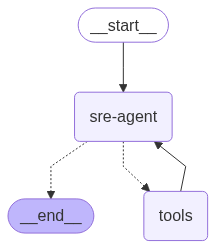

In [74]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "sre-agent")
builder.add_conditional_edges(
    "sre-agent",
    # If the latest message (result) from sre-agent is a tool call -> tools_condition routes to tools
    # If the latest message (result) from sre-agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "sre-agent")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [75]:
import time

async def test_async_graph(graph , human_message: str, trace_name: str = None):
    """Test the graph with proper async execution"""
    # Create a human message from the input
    messages = [HumanMessage(content=human_message)]
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke({"messages": messages}, config)

    # Calculate execution time
    execution_time = time.time() - start_time
    
    # Print results
    for m in result['messages']:
        m.pretty_print()
    
    # Calculate token usage
    total_tokens = 0
    input_tokens = 0
    output_tokens = 0
    
    for m in result['messages']:
        if hasattr(m, 'usage_metadata'):
            if m.usage_metadata:
                if 'input_tokens' in m.usage_metadata:
                    input_tokens += m.usage_metadata['input_tokens']
                if 'output_tokens' in m.usage_metadata:
                    output_tokens += m.usage_metadata['output_tokens']
                if 'total_tokens' in m.usage_metadata:
                    total_tokens += m.usage_metadata['total_tokens']

    result["total_tokens"] = total_tokens
    result["input_tokens"] = input_tokens
    result["output_tokens"] = output_tokens
    result["execution_time"] = execution_time
    
    print(f"\nExecution time: {execution_time:.2f} seconds")
    print(f"Token usage: {total_tokens} total ({input_tokens} input, {output_tokens} output)")
    
    return result

In [76]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE ReAct agent"

In [77]:
human = ""

result_baseline = await test_async_graph(react_graph, human, trace_name=experiment_name)

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_vfji2ER3qTp26QIcXHx2ZuQi)
 Call ID: call_vfji2ER3qTp26QIcXHx2ZuQi
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
================================= Tool Message =================================
Name: kubectl_get

{
  "items": [
    {
      "name": "wrk2-job-967cw",
      "namespace": "default",
      "kind": "Pod",
      "status": "Succeeded",
      "createdAt": "2025-08-21T12:57:42Z"
    },
    {
      "name": "coredns-668d6bf9bc-2d4b9",
      "namespace": "kube-system",
      "kind": "Pod",
      "status": "Running",
      "createdAt": "2025-08-21T12:49:06Z"
    },
    {
      "name": "coredns-668d6bf9bc-2g7c2",
      "namespace": "kube-system",
      "kind": "Pod",
      "status": "Running",
      "createdAt": "2025-08-21T12:49:06Z"
    },
    {
   

In [78]:
# Final AI response
result_baseline["messages"][-1].pretty_print()

================================== Ai Message ==================================

Summary:
- The geo service is CrashLoopBackOff because it cannot connect to its MongoDB. The geo pod is configured to connect to mongodb-geo:27777, but the MongoDB service is listening on 27017. The resulting "no reachable servers" error causes a panic and container exit.

Evidence (collected from the cluster):
- Pod status: geo-6b4b89b5f5-kvvtv is Restarting / CrashLoopBackOff with Ready=False and Restart Count > 0 (describe output shows State: Waiting, Reason: CrashLoopBackOff).
- Geo pod logs:
  - "Read database URL: mongodb-geo:27777"
  - "no reachable servers"
  - panic stacktrace from main.initializeDatabase -> panic: no reachable servers (Exit Code: 2)
  These log lines show the service attempts to connect to MongoDB on port 27777 and fails to reach any server, then panics.
- Services listing for namespace test-hotel-reservation shows mongodb-geo service exposing port 27017 (mongodb-geo 27017/TCP).

In [16]:
import os
import datetime
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

def saveExperiment(experiment_name, result):
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    results_folder = "results"
    os.makedirs(results_folder, exist_ok=True)

    # Create the full path for the file
    file_path = os.path.join(results_folder, f"{timestamp}.txt")

    # Format and write messages to file
    with open(file_path, 'w') as f:
        f.write(f"{'='*50}\nEXPERIMENT SUMMARY\n{'='*50}\n\n")
        if experiment_name:
            f.write(f"Experiment Name: {experiment_name}\n")
        f.write(f"Total tokens used: {result['total_tokens']}\n")
        f.write(f"Input tokens: {result['input_tokens']}\n")
        f.write(f"Output tokens: {result['output_tokens']}\n")
        f.write(f"Execution time: {result['execution_time']:.2f} seconds\n\n")

        f.write(f"{'='*50}\nSYSTEM PROMPT\n{'='*50}\n\n")
        f.write(sys_msg.content + "\n\n")
        

        for i, message in enumerate(result['messages']):
            f.write(f"{'='*50}\nMESSAGE {i+1}\n{'='*50}\n")
            
            if isinstance(message, HumanMessage):
                f.write(f"Type: Human Message\n")
                f.write(f"Content: {message.content}\n\n")
            
            elif isinstance(message, AIMessage):
                f.write(f"Type: AI Message\n")
                if message.content:
                    f.write(f"Content: {message.content}\n\n")
                
                if hasattr(message, 'additional_kwargs') and 'tool_calls' in message.additional_kwargs:
                    tool_calls = message.additional_kwargs['tool_calls']
                    f.write(f"Tool Calls ({len(tool_calls)}):\n")
                    
                    for idx, tool_call in enumerate(tool_calls):
                        f.write(f"  Tool Call {idx+1}: {tool_call['id']}\n")
                        if 'function' in tool_call:
                            f.write(f"    Function: {tool_call['function']['name']}\n")
                            f.write(f"    Arguments: {tool_call['function']['arguments']}\n\n")
            
            elif isinstance(message, ToolMessage):
                f.write(f"Type: Tool Response\n")
                f.write(f"Tool Call ID: {message.tool_call_id}\n")
                f.write(f"Content:\n{message.content}\n\n")
            
            else:
                f.write(f"Type: Other Message Type ({type(message).__name__})\n")
                f.write(f"Content: {str(message)}\n\n")

    print(f"Messages exported to {file_path}")

In [60]:
saveExperiment(experiment_name, result_baseline)

Messages exported to results/20250820_102946.txt


# Improve agent efficiency (in terms of tokens)

## Reduce context by passing only three messages

In [81]:
MAX_MESSAGES = 7

In [90]:
system_prompt_reduced_input = """
You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

The service you are working with today is described below:
{app_summary}

Important constraint:
You only have access to the {max_messages} most recent messages in this conversation. 
Anything older is not visible to you, so do not reference or assume context beyond those last 5 messages.

Your task:
- Begin by analyzing the service's state and telemetry.
- Then submit your solution: describe the issue you have identified (without fixing it).
- Also explain your reasoning and thought process.
- Do not add any followup questions nor additional context.
"""

app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [91]:
llm_with_tools = gpt5mini.bind_tools(tools, parallel_tool_calls=False)

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg_reduced = SystemMessage(content=system_prompt_reduced_input.format(app_summary=app_summary, max_messages=MAX_MESSAGES))

# Node which limits the context window 
async def sreAgent_reducedInput(state: MessagesState):

   messages = state["messages"]

   if len(state["messages"]) <= MAX_MESSAGES:
      return {"messages": [llm_with_tools.invoke([sys_msg_reduced] + messages)]}
   
   # Reduce the context window by taking only the last few messages
   context_messages = []

   # Work backwards from the end
   i = len(messages) - 1
   while i >= 0 and len(context_messages) < (MAX_MESSAGES + 2):
      msg = messages[i]
      context_messages.insert(0, msg)
      
      # If this is a ToolMessage, make sure to include the AIMessage that called it
      if isinstance(msg, ToolMessage) and i > 0:
         prev_msg = messages[i-1]
         if isinstance(prev_msg, AIMessage) and hasattr(prev_msg, 'additional_kwargs'):
               if 'tool_calls' in prev_msg.additional_kwargs and prev_msg not in context_messages:
                  context_messages.insert(0, prev_msg)
      i -= 1

      return {"messages": [llm_with_tools.invoke([sys_msg_reduced] + context_messages)]}




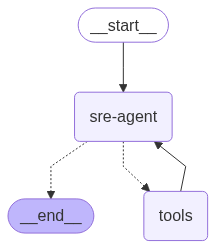

In [92]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("sre-agent", sreAgent_reducedInput)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "sre-agent")
builder.add_conditional_edges(
    "sre-agent",
    # If the latest message (result) from sre-agent is a tool call -> tools_condition routes to tools
    # If the latest message (result) from sre-agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "sre-agent")
react_graph_reduced = builder.compile()

# Show
display(Image(react_graph_reduced.get_graph(xray=True).draw_mermaid_png()))

In [93]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE ReAct agent"

In [94]:
human = ""

result_reduced = await test_async_graph(react_graph_reduced, human, trace_name=experiment_name)

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_5jm7pQypdeQK6Mfez63lXJHq)
 Call ID: call_5jm7pQypdeQK6Mfez63lXJHq
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS       AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-ckmtv                                             0/1     Completed          0              57m   10.244.1.52   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-66rlq                                   1/1     Running            0              75m   10.244.0.

In [95]:
# Final AI answer
result_reduced["messages"][-1].pretty_print()

================================== Ai Message ==================================

Summary of issue
- The geo service is failing to start because it panics while trying to connect to MongoDB. Logs show a connection failure "no reachable servers" when attempting to initialize the DB at mongodb-geo:27777, and the process panics as a result.

Relevant evidence from telemetry
- From the geo pod logs (timestamps included):
  - "Read database URL: mongodb-geo:27777"
  - "Initializing DB connection..."
  - "no reachable servers"
  - panic stack trace (main.initializeDatabase -> cmd/geo/db.go:26 and main/main.go:38)
- The service logs indicate TLS disabled and normal startup until the DB connect attempt, then immediate panic.

Behavior/impact
- The geo service crashes on startup due to an unhandled DB connection error (log.Panic is called), likely causing restart loops and making the geo service unavailable. Any components depending on geo (e.g., geolocation lookups or recommender) will be impa

In [96]:
saveExperiment(experiment_name, result_reduced)

Messages exported to results/20250820_110435.txt


## Use custom structured schema

This approach improves token efficiency by replacing the full message history with a structured summary. Instead of passing all previous messages to the LLM, the agent maintains:

- **`insights`**: Key findings from each investigation step
- **`prev_steps`**: Concise descriptions of actions taken
- **`response`**: Final diagnosis when investigation is complete

After each tool execution, a `summarise` node extracts the most important information and updates the structured state. This allows the agent to maintain context while significantly reducing token usage compared to the baseline approach.

In [79]:
from typing import TypedDict, List, Literal, Annotated
from langgraph.graph.message import add_messages, AnyMessage
import operator

class SREAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    insights: Annotated[list[str], operator.add]
    prev_steps: Annotated[list[str], operator.add]
    response: str

In [80]:
sre_agent_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the Kubernetes cluster.

    Context:

    *Previous Steps:*
    {prev_steps}

    *Insights:*
    {insights}

    Your task:
        1. Begin by analyzing the service's state and telemetry using kubectl tools
        2. When you have identified the issue, call the submit_final_diagnosis tool with:
            - diagnosis: Describe the issue you have identified (without fixing it)
            - reasoning: Explain your reasoning and thought process behind the solution

    IMPORTANT: You must call submit_final_diagnosis when you're ready to conclude your investigation.
"""

app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [81]:
summarise_prompt = """
    You are an autonomous SRE agent for Kubernetes incident diagnosis.

    Context:

    Previous Insights: 
    {insights}
    
    Previous Steps:
    {prev_steps}

    Below are the latest two messages:
    {last_two_messages}

    Instructions:
    1. From the latest two messages, extract the most important new insight relevant for incident diagnosis or mitigation. Summarize it concisely.
    2. Write a concise description of only the most recent action taken including the tool used (not the whole list).  
"""

In [82]:
from pydantic import BaseModel, Field

class UpdateAgentData(BaseModel):
    """
    Represents a step performed by the SRE agent.
    """
    insight: str = Field(..., description="Most important new finding")
    prev_step: str = Field(..., description="Concise description of the most recent action taken")

In [83]:
llm_with_strct_output = gpt5mini.with_structured_output(UpdateAgentData)

In [84]:
from langchain_core.messages import HumanMessage

# Node used to summarise the infos given the two previous messages
async def summarise(state: SREAgentState):

    # Gather last two messages (tool call + tool response)
    last_messages = state["messages"][-2:]

    if len(state["insights"]) > 0:
        insights_str = "\n- ".join([""] + state["insights"])
    else:
        insights_str = "No insights yet"

    if len(state["prev_steps"]) > 0:
        prev_step_str = "\n- ".join([""] + state["prev_steps"])
    else:
        prev_step_str = "No previous steps yet"

    prompt = HumanMessage(content=summarise_prompt.format(prev_steps = prev_step_str, insights=insights_str, last_two_messages=last_messages))

    data = llm_with_strct_output.invoke([prompt])

    return {"insights" : [data.insight], "prev_steps" : [data.prev_step]}

In [85]:
from typing import Annotated
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId

# Tool used to submit the final response
@tool
def submit_final_diagnosis(
    diagnosis: str, 
    reasoning: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Submit the final diagnosis when investigation is complete.
    
    Args:
        diagnosis: The issue you have identified (without fixing it)
        reasoning: Your reasoning and thought process behind the diagnosis
    
    Returns:
        Command to update state and end workflow
    """
    final_response = f"{diagnosis}\n\nReasoning: {reasoning}"
    
    return Command(
        update={
            "response": final_response, # Add in the final graph state the final answer
            "messages": [
                ToolMessage(
                    content="Final diagnosis submitted successfully. Investigation complete.",
                    tool_call_id=tool_call_id
                )
            ]
        },
        goto="__end__" # End the loop cycle
    )

# Append the tool for submission to the list of tools (MCP servers)
completion_tool = submit_final_diagnosis
tools_with_completion = tools + [completion_tool]

In [86]:
async def sreAgent(state: SREAgentState):
    if len(state["insights"]) > 0:
        insights_str = "\n- ".join([""] + state["insights"])
    else:
        insights_str = "No insights yet"

    if len(state["prev_steps"]) > 0:
        prev_step_str = "\n- ".join([""] + state["prev_steps"])
    else:
        prev_step_str = "No previous steps yet"

    prompt = HumanMessage(content=sre_agent_prompt.format(
        prev_steps=prev_step_str, 
        insights=insights_str, 
        app_summary=app_summary
    ))

    # Use tools with completion (for the submission)
    llm_with_completion_tools = gpt5mini.bind_tools(tools_with_completion, parallel_tool_calls=False)
    return {"messages": [llm_with_completion_tools.invoke([prompt])]}

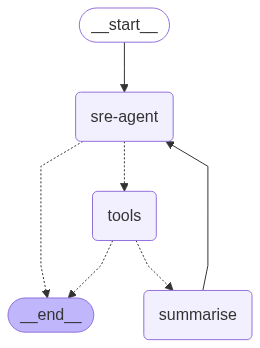

In [87]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Build the graph
builder = StateGraph(SREAgentState)

# Add nodes
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(tools_with_completion)) # Tool node is executing the tool called in the previous message
builder.add_node("summarise", summarise) # Node to reduce the raw data into a schema

# Add edges
builder.add_edge(START, "sre-agent")

# Conditional edge from sre-agent
builder.add_conditional_edges(
    "sre-agent",
    #Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    tools_condition,
)

# After tools, decide whether to summarise or end
def after_tools_condition(state: SREAgentState):
    # If response is filled, investigation is complete (end of the workflow)
    if state.get("response"):
        return END
    return "summarise"

builder.add_conditional_edges(
    "tools",
    after_tools_condition,
    {
        "summarise": "summarise",
        END: END
    }
)

# After summarise, continue investigation (go to sre-agent)
builder.add_edge("summarise", "sre-agent")

# Compile the graph
structured_graph = builder.compile()

# Show the graph
display(Image(structured_graph.get_graph(xray=True).draw_mermaid_png()))

In [88]:
import time

async def test_structured_graph(graph, human_message: str = "", trace_name: str = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "messages": [HumanMessage(content=human_message)] if human_message else [],
        "insights": [],
        "prev_steps": [],
        "response": ""
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    return result

In [89]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE structured format agent"

In [90]:
human = ""
structured_result = await test_structured_graph(structured_graph, human, experiment_name)

In [94]:
for step in structured_result["prev_steps"]:
    print(step)

Executed kubectl_get to list pods across all namespaces (kubectl get pods --all-namespaces -o wide).
Ran kubectl_describe on pod geo in namespace test-hotel-reservation (kubectl describe pod geo -n test-hotel-reservation).
Tried to retrieve the last 200 lines of logs from pod 'geo' in namespace test-hotel-reservation using kubectl_logs; the tool returned “Resource pod geo not found.”
Executed kubectl_get for pods in namespace test-hotel-reservation with output=json to list pods (found geo-6b4b89b5f5-kvvtv).
Ran kubectl_describe on pod geo-6b4b89b5f5-kvvtv in namespace test-hotel-reservation.
Fetched the last 200 lines of logs from pod geo-6b4b89b5f5-kvvtv using kubectl_logs.
Called kubectl_get to list pods in namespace test-hotel-reservation (kubectl get pods -n test-hotel-reservation -o json).
Ran kubectl_get to list services in test-hotel-reservation (kubectl get services -n test-hotel-reservation -o json).
Ran kubectl_get to fetch the Endpoints resource 'mongodb-geo' in namespace te

In [95]:
for insight in structured_result["insights"]:
    print(insight)

The pod test-hotel-reservation/geo is in CrashLoopBackOff (0/1) with 11 restarts — a failing container likely causing the incident.
The container hotel-reserv-geo is in CrashLoopBackOff with RestartCount=11 and the last termination had Exit Code 2 — indicating the application is failing on startup (an app error), not an image pull or scheduling problem (image pulls and container starts succeeded).
Attempt to fetch pod logs failed because the pod 'geo' was not found (kubectl_logs returned “Resource pod geo not found”), meaning the pod may have been deleted/renamed or the name/namespace is incorrect.
A pod named geo-6b4b89b5f5-kvvtv exists in namespace test-hotel-reservation and is in Running state (created 2025-08-21T12:57:25Z). The prior “pod not found” was due to using the short name ‘geo’ — fetch logs/describe using the full pod name to investigate startup restarts.
Described pod geo-6b4b89b5f5-kvvtv: the container hotel-reserv-geo is in CrashLoopBackOff with RestartCount=11 and Last

In [96]:
print(structured_result["response"])

geo service (container hotel-reserv-geo) is crashing on startup (CrashLoopBackOff) because it cannot connect to MongoDB: it attempts to reach mongodb-geo:27777 but the MongoDB endpoints are on port 27017. This port mismatch prevents the geo app from establishing a DB connection and causes the startup panic.

Reasoning: Observed evidence:
- Pod geo-6b4b89b5f5-kvvtv shows container in CrashLoopBackOff with RestartCount=11 and last terminated with Exit Code 2 (application error on startup).
- Pod logs show the application panicked with "no reachable servers" while initializing a DB connection to mongodb-geo:27777.
- The mongodb-geo pod (mongodb-geo-5ff578bcb8-l4ftr) is Running and the mongodb-geo Service exists, so the database pod and Service are present.
- Endpoints for the mongodb-geo Service point to the MongoDB pod at port 27017 (default MongoDB port), not 27777.
Reasoning: because the geo application is trying to connect to port 27777 while the actual MongoDB listens on 27017 (and E

In [97]:
for message in structured_result["messages"]:
    message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_Bha65hnmkVsF4nN6h0IAB0Xd)
 Call ID: call_Bha65hnmkVsF4nN6h0IAB0Xd
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS       AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-967cw                                             0/1     Completed          0              37m   10.244.1.31   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-2d4b9                                   1/1     Running            0              45m   10.244.0.3    kind-control-plane   <none>           <none>
kube-system              coredns-